In [385]:
%matplotlib inline

# LAB 4 - Forcing SHELL-E model with temperature from satellites (POES, AVHRR and GAC)

MARI4600/BIO5600: Ecosystem Modelling for Aquaculture (Dalhousie University)

----------------------------------------

**Rendered link:** http://nbviewer.jupyter.org/urls/bitbucket.org/Diego_Ibarra/aquaculturemodelling2017/raw/tip/Week4/LAB%204%20Forcing%20SHELL-E%20model%20with%20temperature%20from%20satellites.ipynb

--------------------------------------


<span class="important"></span> This demo requires a copy of the <span class='file'>model_SHELLE.py</span> file we made in the previous lab. I placed a copy in Brightspace, download it and place it in your working directory.

<span class="important"></span> You will need 3 modules, `netCDF4` to handle <span class='file'>.nc</span> files, `cartopy` to make maps, and `cmocean` for additional colormaps. If these modules are not already installed in your computer, you will need to install them via the `Anaconda Prompt`. To do this, search in the Windows Taskbar for `Anaconda Prompt`.

<span class="important"></span> You need to run the `Anaconda Prompt` as an Administrator. To do this, (1) search in the Windows Taskbar for `Anaconda Prompt`, and (2) right click on the `Anaconda Prompt` icon in the menu and select "more" > "Run as Administrator"

In the <span class='terminal'></span>, copy-paste the following, then click [Enter] and finally, when asked, type [y]:

<div class='terminalBlock'>conda install -c anaconda netcdf4</div>

then..

<div class='terminalBlock'>conda install -c conda-forge cartopy cmocean</div>


Then, in Spyder, create 3 new empty files. Save one as as <span class='file'>mapSST.py</span>, other as <span class='file'>timeSeriesSST.py</span> and the last as <span class='file'>GlobalWarming_experiment.py</span>.

1. We will write code in <span class='file'>mapSST.py</span> to demonstrate how to get SST data. We will also make maps.

1. Then, we will write code in <span class='file'>timeSeriesSST.py</span> to download SST data in a time-series format, and to "wrangle" the data to be suitable for forcing in our model.

1. Finally we will use <span class='file'>GlobalWarming_experiment.py</span> to assess what may happen in several Global Warming scenarios.


----------------------

# PART 1: Getting SST data and making maps

## Finding Temperature data (ERDDAP)

Open a browser, Google "ERDDAP NOAA" and go to the 1st link. Then, the on right top corner, click on `View a List of All #### Datasets`

...or simply go here: https://coastwatch.pfeg.noaa.gov/erddap/info/index.html?page=1&itemsPerPage=1000

-------------------------


## Finding Satellite SST (Sea Surface Temperature) within NOAA's ERDDAP

Find (Control+F): `SST, POES AVHRR, GAC, Global, Day and Night`

Click on `data` on the row with title `SST, POES AVHRR, GAC, Global, Day and Night, 2003-201# (Monthly Composite), Lon+/-180`. 

...or simply go here: https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.html
        
---------------

## Generate download URL

In the ERDDAP webpage, input the follwong values in the respective "boxes":

* Time Start: 2015-08-16T12:00:00Z
* Time Stop:  2015-08-16T12:00:00Z
* Altitude Start: 0.0
* Altitude Stop:  0.0
* Latitude Start: 38.0
* Latitude Stop:  48.0
* Longitude Start: -68.0
* Longitude Stop:  -50.0
* File type: .nc

Click `Just generate URL`...

In <span class='file'>mapSST.py</span>, create a variable called `URL` and copy-paste the url that you just generated in the ERDDAP website. Your file should look like the checkpoint below. Save and <span class="run"></span> your file.

<span class="checkpoint">CHECKPOINT below...</span> 

In [386]:
URL = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?sst[(2015-08-16T12:00:00Z):1:(2015-08-16T12:00:00Z)][(0.0):1:(0.0)][(38):1:(48)][(-68):1:(-50)]'

Then, in your console, type:

<div class="c2c"></div>

In [387]:
URL

'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?sst[(2015-08-16T12:00:00Z):1:(2015-08-16T12:00:00Z)][(0.0):1:(0.0)][(38):1:(48)][(-68):1:(-50)]'

Note that all the arguments you input in the ERDDAP website (i.e. Time Start, Time Stop, Latitude Start, File type, etc) are embedded in the generated url. In fact, the url is how you tell ERDDAP what data do you want. 

For future use and to make it easier to change the dates/lats/lons, we can make variables and then concatenate the variables into the full URL. Replace the contents of <span class='file'>mapSST.py</span> for the following:

<span class="checkpoint">CHECKPOINT below...</span> 

In [388]:
year = 2015
month = 8
minlat = 38
maxlat = 48
minlon = -68
maxlon = -50
isub = 1 # Stride

minday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'
maxday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'

base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?'
query='sst[('+minday+'):'+str(isub)+':('+maxday+')][(0.0):'+str(isub)+':(0.0)][('+str(minlat)+'):'+str(isub)+':('+str(maxlat)+')][('+str(minlon)+'):'+str(isub)+':('+str(maxlon)+')]'
URL = base_url+query

Then, in your console, type:

<div class="c2c"></div>

In [389]:
URL

'https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?sst[(2015-08-16T12:00:00Z):1:(2015-08-16T12:00:00Z)][(0.0):1:(0.0)][(38):1:(48)][(-68):1:(-50)]'

Note that after the variables got concatenated, the resulting `URL` variable is identical as the origincal url we copy-pasted from ERDDAP's webpage.

## Download SST data

Now we are going to use the `urllib` module to download data from the ERDDAP server into a your local computer (we'll save the data in new file called <span class='file'>sst.nc</span>).

Add the following NEW LINES to your file, and click <span class='run'></span>

<span class="checkpoint">CHECKPOINT below...</span> 

In [390]:
import urllib.request  # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<

year = 2015
month = 8
minlat = 38
maxlat = 48
minlon = -68
maxlon = -50
isub = 1 # Stride

minday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'
maxday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'

base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?'
query='sst[('+minday+'):'+str(isub)+':('+maxday+')][(0.0):'+str(isub)+':(0.0)][('+str(minlat)+'):'+str(isub)+':('+str(maxlat)+')][('+str(minlon)+'):'+str(isub)+':('+str(maxlon)+')]'
URL = base_url+query

# Download data and store it in NetCDF file <<<<<< NEW LINE !!!!! <<<<<<
fileName='sst.nc' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<
urllib.request.urlretrieve(URL, fileName) # <<<<<<<<<<<<< NEW LINE !!!!! <<<<<<

('sst.nc', <http.client.HTTPMessage at 0x22b03ebbac8>)

Make sure that the new file <span class='file'>sst.nc</span> got made and saved in your working directory.

-----------------

## Exploring our temperature data

Before we start exploring the data we just downloaded, we are going to "Comment Out" the line of code `urllib.request.urlretrieve(URL, fileName)`, where we download data from the ERDDAP server, so that we don't download data again every time we run our code (downloading once is enough). A few years ago, we crashed NOAA's ERDDAP server for two days because too many students downloaded data too many times. We don't want that to happen again :(

To "Comment Out" the line where we download data simply add a `#` in front of the line that says `urllib.request.urlretrieve(URL, fileName)`. Adding the `#` makes the whole line a comment, thus it gets ignored by Python. You can remove the `#` when you want to activate the line again. "Commenting Out" is useful during developing, but MAKE SURE to remember to remove the `#` next time you actually want to download data. Your code should look as below:

<span class="checkpoint">CHECKPOINT below...</span> 

In [391]:
import urllib.request

year = 2015
month = 8
minlat = 38
maxlat = 48
minlon = -68
maxlon = -50
isub = 1 # Stride

minday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'
maxday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'

base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?'
query='sst[('+minday+'):'+str(isub)+':('+maxday+')][(0.0):'+str(isub)+':(0.0)][('+str(minlat)+'):'+str(isub)+':('+str(maxlat)+')][('+str(minlon)+'):'+str(isub)+':('+str(maxlon)+')]'
URL = base_url+query

# Download data and store it in NetCDF file 
fileName='sst.nc'
#urllib.request.urlretrieve(URL, fileName) # <<<<<<<<<<<<< Commented out !!!!! <<<<<<

## Reading data out of a NetCDF file

Here you'll need the `netcdf4` module. You probably already have it installed (i.e. skip this step). If not, open an `Anaconda Prompt` and type:


<div class='terminalBlock'>conda install -c anaconda netcdf4</div>


Now, it is time modify you <span class='file'>mapSST.py</span> to read the data you just downloaded:

* At the top of <span class='file'>mapSST.py</span> import the `netCDF` module. 
* At the bottom of <span class='file'>mapSST.py</span> read the file using the lines shown below:

Once you added the new lines, <span class="run"></span> your file.

<span class="checkpoint">CHECKPOINT below...</span> 

In [392]:
import urllib.request
import netCDF4 # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<

year = 2015
month = 8
minlat = 38
maxlat = 48
minlon = -68
maxlon = -50
isub = 1 # Stride

minday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'
maxday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'

base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?'
query='sst[('+minday+'):'+str(isub)+':('+maxday+')][(0.0):'+str(isub)+':(0.0)][('+str(minlat)+'):'+str(isub)+':('+str(maxlat)+')][('+str(minlon)+'):'+str(isub)+':('+str(maxlon)+')]'
URL = base_url+query

# Download data and store it in NetCDF file
fileName='sst.nc' 
urllib.request.urlretrieve(URL, fileName)

#%% open NetCDF data from file # <<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<
nc = netCDF4.Dataset(fileName)   # <<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<

All the contents of the netCDF file are in our new variable `nc`. Let's take a look inside `nc`

<div class="c2c"></div>

In [393]:
type(nc)

netCDF4._netCDF4.Dataset

<div class="c2c"></div>

In [394]:
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    acknowledgement: NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type: Grid
    composite: true
    contributor_name: NOAA NESDIS OSDPD
    contributor_role: Source of level 2 data.
    Conventions: COARDS, CF-1.6, ACDD-1.3
    creator_email: erd.data@noaa.gov
    creator_name: NOAA NMFS SWFSC ERD
    creator_type: institution
    creator_url: https://www.pfeg.noaa.gov
    date_created: 2016-05-03
    date_issued: 2016-05-03
    Easternmost_Easting: -50.0
    geospatial_lat_max: 48.0
    geospatial_lat_min: 38.0
    geospatial_lat_resolution: 0.1
    geospatial_lat_units: degrees_north
    geospatial_lon_max: -50.0
    geospatial_lon_min: -68.0
    geospatial_lon_resolution: 0.09999999999999999
    geospatial_lon_units: degrees_east
    geospatial_vertical_max: 0.0
    geospatial_vertical_min: 0.0
    geospatial_vertical_positive: up
    geospatial_vertical_units: m
    history: NOA

--------------

As you can see, a lot of metadata is contained inside `nc`. NetCDF files are "self-descriptive" which means that they contain the data PLUS all the ancillary information required to make sense of the data. NetCDF files have `dimensions`, `variables` and `attributes`. The first two are accessed, via the `.dimensions` and `.variables` methods (e.g. `nc.dimensions`, `nc.variables`). The attributes are also accessed via methods, but their method name is specified by whoever made the NetCDF file and may vary depending on source. Additionally, some attributes are Global (i.e. they apply to the entire dataset), but each variable may also have its own set of attributes.

Lets take a look at the dimensions of `nc`.

<div class="c2c"></div>

In [395]:
nc.dimensions

OrderedDict([('time',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1),
             ('altitude',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'altitude', size = 1),
             ('latitude',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 101),
             ('longitude',
              <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 181)])

Lets take a look at the `contributor_name` attribute of `nc`.

<div class="c2c"></div>

In [396]:
nc.contributor_name

'NOAA NESDIS OSDPD'

Now lets further extract the variables from the `nc` file and place them in `ncv`.

Take a look at the new lines in the checkpoint below. Once you added the new lines to <span class='file'>mapSST.py</span>, <span class="run"></span> it.

<span class="checkpoint">CHECKPOINT below...</span> 

In [397]:
import urllib.request
import netCDF4

year = 2015
month = 8
minlat = 38
maxlat = 48
minlon = -68
maxlon = -50
isub = 1 # Stride

minday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'
maxday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'

base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?'
query='sst[('+minday+'):'+str(isub)+':('+maxday+')][(0.0):'+str(isub)+':(0.0)][('+str(minlat)+'):'+str(isub)+':('+str(maxlat)+')][('+str(minlon)+'):'+str(isub)+':('+str(maxlon)+')]'
URL = base_url+query

# Download data and store it in NetCDF file 
fileName='sst.nc' 
#urllib.request.urlretrieve(URL, fileName)

#%% open NetCDF data from file
nc = netCDF4.Dataset(fileName)
ncv = nc.variables # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<

After you <span class="run"></span> your file, take a look at the new `ncv`:

<div class="c2c"></div>

In [398]:
ncv

OrderedDict([('time', <class 'netCDF4._netCDF4.Variable'>
              float64 time(time)
                  _CoordinateAxisType: Time
                  actual_range: [1.4397264e+09 1.4397264e+09]
                  axis: T
                  fraction_digits: 0
                  ioos_category: Time
                  long_name: Centered Time
                  standard_name: time
                  time_origin: 01-JAN-1970 00:00:00
                  units: seconds since 1970-01-01T00:00:00Z
              unlimited dimensions: 
              current shape = (1,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('altitude', <class 'netCDF4._netCDF4.Variable'>
              float64 altitude(altitude)
                  _CoordinateAxisType: Height
                  _CoordinateZisPositive: up
                  actual_range: [0. 0.]
                  axis: Z
                  fraction_digits: 0
                  ioos_category: Location
                  lon

Once again, there is a lot of metadata inside the variables. 

Let's see what type of object is `ncv`. 

<div class="c2c"></div>

In [399]:
type(ncv)

collections.OrderedDict

It is a "Dictionary". Let's see what are its "keys":

<div class="c2c"></div>

In [400]:
ncv.keys()

odict_keys(['time', 'altitude', 'latitude', 'longitude', 'sst'])

To see what is inside one of variables of `ncv`, you can use any of the keys: 

<div class="c2c"></div>

In [401]:
ncv['latitude']

<class 'netCDF4._netCDF4.Variable'>
float64 latitude(latitude)
    _CoordinateAxisType: Lat
    actual_range: [38. 48.]
    axis: Y
    coordsys: geographic
    fraction_digits: 1
    ioos_category: Location
    long_name: Latitude
    point_spacing: even
    standard_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (101,)
filling on, default _FillValue of 9.969209968386869e+36 used

Note `current shape = (101,)`. This means that `ncv['latitude']` only has one dimension. It is ONE column with 101 rows. To actually get at the data. You need to call ALL the rows in the dimension of interest:

<div class="c2c"></div>

In [402]:
ncv['latitude'][:]

masked_array(data=[38. , 38.1, 38.2, 38.3, 38.4, 38.5, 38.6, 38.7, 38.8,
                   38.9, 39. , 39.1, 39.2, 39.3, 39.4, 39.5, 39.6, 39.7,
                   39.8, 39.9, 40. , 40.1, 40.2, 40.3, 40.4, 40.5, 40.6,
                   40.7, 40.8, 40.9, 41. , 41.1, 41.2, 41.3, 41.4, 41.5,
                   41.6, 41.7, 41.8, 41.9, 42. , 42.1, 42.2, 42.3, 42.4,
                   42.5, 42.6, 42.7, 42.8, 42.9, 43. , 43.1, 43.2, 43.3,
                   43.4, 43.5, 43.6, 43.7, 43.8, 43.9, 44. , 44.1, 44.2,
                   44.3, 44.4, 44.5, 44.6, 44.7, 44.8, 44.9, 45. , 45.1,
                   45.2, 45.3, 45.4, 45.5, 45.6, 45.7, 45.8, 45.9, 46. ,
                   46.1, 46.2, 46.3, 46.4, 46.5, 46.6, 46.7, 46.8, 46.9,
                   47. , 47.1, 47.2, 47.3, 47.4, 47.5, 47.6, 47.7, 47.8,
                   47.9, 48. ],
             mask=False,
       fill_value=1e+20)

Now, lets try `ncv['sst']`:

<div class="c2c"></div>

In [403]:
ncv['sst']

<class 'netCDF4._netCDF4.Variable'>
float32 sst(time, altitude, latitude, longitude)
    _FillValue: -9999999.0
    colorBarMaximum: 32.0
    colorBarMinimum: 0.0
    coordsys: geographic
    fraction_digits: 1
    ioos_category: Temperature
    long_name: Sea Surface Temperature
    missing_value: -9999999.0
    standard_name: sea_surface_temperature
    units: degree_C
unlimited dimensions: 
current shape = (1, 1, 101, 181)
filling on

<span class="note"></span> THIS IS NEW. Lets take a look at the shape of `ncv['sst']` by using the `.shape` method:

<div class="c2c"></div>

In [404]:
ncv['sst'].shape

(1, 1, 101, 181)

When working with matrices the "length" is not at important as the **"shape"** of the matrix. The `.shape` method is very useful when assessing matrices, but it only works in some objects (like numpy matrices).

The shape of `ncv['sst']` is `(1, 1, 101, 181)`, which is a bit hard to explain. Lets use a "made up" example:

Lets suppose that we have the output of a 3D numerical model that produces a three-dimentional matrix every single time-step. The actual output is a forth-dimessional matrix, which is hard to show visually, nevertheless below I tried to make a graphical representation of such output:

<img src="./grid_diagram.png">

Although in the diagram above I represented the output as a collection of 3D matrices, the output of these kind of models are actually a forth-dimensional matrix... for example of shape `(1250, 10, 101, 181)` for 1250 time-steps, 10 depths, 101 latitudes and 181 longitudes. In `ncv['sst']`, the output follows this convension, however in this case `ncv['sst']` has a shape of `(1, 1, 101, 181)`, which means that it contains 1 time-step, 1 depth (i.e. surface), 101 latitudes and 181 longitudes. 

In the theoretical example above (with our `(1250, 10, 101, 181)` matrix), if you want to make a map of the "surface" layer, you would have to "slice" your data. That is, you need to get a two-dimensional "slice" that is suitable for making a map (e.g. all latitudes and all longitudes, but only for the "surface" depth and one time-step) .

In the case of `ncv['sst']`, there is only 1 time-step and 1 depth (i.e. surface). However, Python still sees the data as inside a forth-dimensional matrix. Therefore we still need to extract a "slice". To actually get at the data you want, you need to call ALL the rows in the dimension of interest. Here is how you do it:

<div class="c2c"></div>

In [405]:
sst = ncv['sst'][0,0,:,:]

<div class="Q"><br>

What is the shape of <b>ncv['sst']</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What is the shape of the newly created <b>sst</b>?

<br><br><div class="qhelp"></div></div>

Make sure you understand the concept of "slicing data". It is very useful.

----------------------

Now that we extracted our data into `sst`, lets take a quick pic to see how it looks:

<div class="c2c"></div>

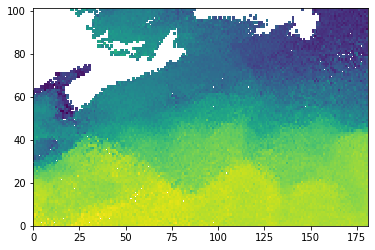

In [406]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
ax.pcolor(sst)

Can you see Nova Scotia?

This plot shows the "raw" data. There is no latitudes or longitudes or "projection", so it not quite a map just yet. But at least we can see that there is data (i.e. it is not a blank plot).

To make a real map, first we'll extract the variables of interest from the `nc` file and store them in `lon`, `lat` and `sst` variables.

Take a look at the new lines in the checkpoint below. Once you added the new lines to <span class='file'>mapSST.py</span>, <span class="run"></span> it.

<span class="checkpoint">CHECKPOINT below...</span> 

In [407]:
import urllib.request
import netCDF4

year = 2015
month = 8
minlat = 38
maxlat = 48
minlon = -68
maxlon = -50
isub = 1 # Stride

minday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'
maxday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'

base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?'
query='sst[('+minday+'):'+str(isub)+':('+maxday+')][(0.0):'+str(isub)+':(0.0)][('+str(minlat)+'):'+str(isub)+':('+str(maxlat)+')][('+str(minlon)+'):'+str(isub)+':('+str(maxlon)+')]'
URL = base_url+query

# Download data and store it in NetCDF file 
fileName='sst.nc' 
#urllib.request.urlretrieve(URL, fileName)

#%% open NetCDF data from file
nc = netCDF4.Dataset(fileName)
ncv = nc.variables 

#%% Extract relevant data from ncv # <<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<
lon = ncv['longitude'][:] # <<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<
lat = ncv['latitude'][:] # <<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<
sst = ncv['sst'][0,0,:,:] # <<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<

Lets take a look at `lat`:

<div class="c2c"></div>

In [408]:
lat

masked_array(data=[38. , 38.1, 38.2, 38.3, 38.4, 38.5, 38.6, 38.7, 38.8,
                   38.9, 39. , 39.1, 39.2, 39.3, 39.4, 39.5, 39.6, 39.7,
                   39.8, 39.9, 40. , 40.1, 40.2, 40.3, 40.4, 40.5, 40.6,
                   40.7, 40.8, 40.9, 41. , 41.1, 41.2, 41.3, 41.4, 41.5,
                   41.6, 41.7, 41.8, 41.9, 42. , 42.1, 42.2, 42.3, 42.4,
                   42.5, 42.6, 42.7, 42.8, 42.9, 43. , 43.1, 43.2, 43.3,
                   43.4, 43.5, 43.6, 43.7, 43.8, 43.9, 44. , 44.1, 44.2,
                   44.3, 44.4, 44.5, 44.6, 44.7, 44.8, 44.9, 45. , 45.1,
                   45.2, 45.3, 45.4, 45.5, 45.6, 45.7, 45.8, 45.9, 46. ,
                   46.1, 46.2, 46.3, 46.4, 46.5, 46.6, 46.7, 46.8, 46.9,
                   47. , 47.1, 47.2, 47.3, 47.4, 47.5, 47.6, 47.7, 47.8,
                   47.9, 48. ],
             mask=False,
       fill_value=1e+20)

To see what type of object is `lat`:

<div class="c2c"></div>

In [409]:
type(lat)

numpy.ma.core.MaskedArray

To see the shape of `lat`:

<div class="c2c"></div>

In [410]:
lat.shape

(101,)

To see what is the minimum value of `lat`:

<div class="c2c"></div>

In [411]:
lat.min()

38.0

To see what is the maximum value of `lat`:

<div class="c2c"></div>

In [412]:
lat.max()

48.0

<div class="Q"><br>

What is the shape of <b>lat</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What is the smallest number in <b>lat</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What is the largest number in <b>lat</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What type of object is <b>lon</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What is the shape of <b>lon</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What is the smallest number in <b>lon</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What is the largest number in <b>lon</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What type of object is <b>sst</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What is the shape of <b>sst</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What is the smallest number in <b>sst</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What is the largest number in <b>sst</b>?

<br><br><div class="qhelp"></div></div>

To make maps, we need two-dimensional representations of our current one-dimensional `lat` and `lon`. Sound's complicated, but in reality is only one line of code. Take a look at the new lines in the checkpoint below. Once you added the new lines to <span class='file'>mapSST.py</span>, <span class="run"></span> it.

<span class="checkpoint">CHECKPOINT below...</span> 

In [413]:
import urllib.request
import netCDF4
import numpy as np # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<

year = 2015
month = 8
minlat = 38
maxlat = 48
minlon = -68
maxlon = -50
isub = 1 # Stride

minday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'
maxday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'

base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?'
query='sst[('+minday+'):'+str(isub)+':('+maxday+')][(0.0):'+str(isub)+':(0.0)][('+str(minlat)+'):'+str(isub)+':('+str(maxlat)+')][('+str(minlon)+'):'+str(isub)+':('+str(maxlon)+')]'
URL = base_url+query

# Download data and store it in NetCDF file 
fileName='sst.nc' 
#urllib.request.urlretrieve(URL, fileName)

#%% open NetCDF data from file
nc = netCDF4.Dataset(fileName)
ncv = nc.variables 

#%% Extract relevant data from ncv 
lon = ncv['longitude'][:] 
lat = ncv['latitude'][:] 
sst = ncv['sst'][0,0,:,:]

#%% Make a grid # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<
lons, lats = np.meshgrid(lon,lat) # <<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<

Note that we created two new variables `lats` and `lons`. Lets plot them to understand how they look.
<div class="c2c"></div>

Text(0.5, 1.0, 'lons')

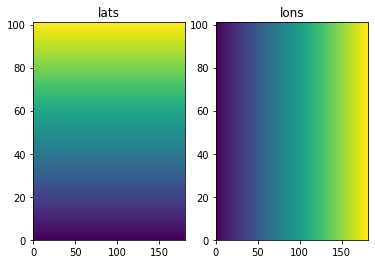

In [414]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.pcolor(lats)
ax1.set_title('lats')
ax2.pcolor(lons)
ax2.set_title('lons')

While `lat` and `lon` are single columns, `lats` and `lons` (note the "s" at the end) are two-dimensional matrices. In `lats`, all the **columns** in every row have the same latitude. In `lons`, all the **rows** in every column have the same longitude.

Again, the reason we did this is because our mapping function requires latitudes and longitudes to be in two-dimensional form.

<div class="Q"><br>

What is the shape of <b>lats</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

What is the shape of <b>lons</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

Lets ask this again, what is the shape of <b>sst</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

Do <b>sst</b>, <b>lats</b> and <b>lons</b> have the same shape?

<br><br><div class="qhelp"></div></div>

## Mapping

Here you'll need the `cartopy` and `cmocean` modules. You probably already have them installed (i.e. skip this step). If not, open an `Anaconda Prompt` and type:


<div class='terminalBlock'>conda install -c conda-forge cartopy cmocean</div>


Time to make maps!

Take a look at the new lines in the checkpoint below. Once you added the new lines to <span class='file'>mapSST.py</span>, <span class="run"></span> it.

<span class="checkpoint">CHECKPOINT below...</span> 

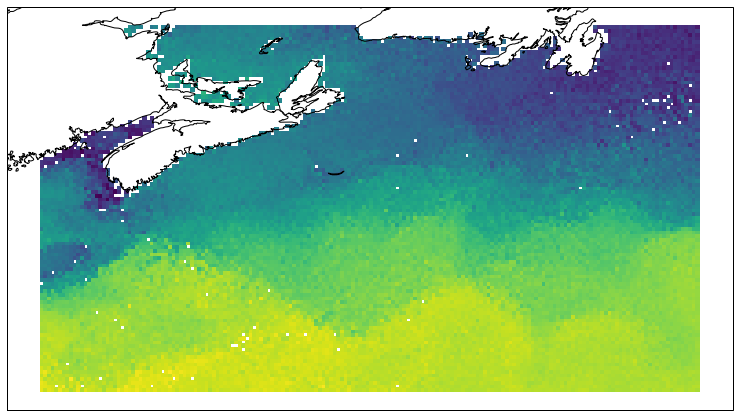

In [415]:
import urllib.request
import netCDF4
import numpy as np 
import matplotlib.pyplot as plt # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<
import cartopy.crs as ccrs # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<
import cartopy.feature as cfeature # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<
import cmocean # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW LINE !!!!! <<<<<<

year = 2015
month = 8
minlat = 38
maxlat = 48
minlon = -68
maxlon = -50
isub = 1 # Stride

minday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'
maxday = str(year)+'-'+str(month).zfill(2)+'-16T12:00:00Z'

base_url='https://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.nc?'
query='sst[('+minday+'):'+str(isub)+':('+maxday+')][(0.0):'+str(isub)+':(0.0)][('+str(minlat)+'):'+str(isub)+':('+str(maxlat)+')][('+str(minlon)+'):'+str(isub)+':('+str(maxlon)+')]'
URL = base_url+query

# Download data and store it in NetCDF file 
fileName='sst.nc' 
#urllib.request.urlretrieve(URL, fileName)

#%% open NetCDF data from file
nc = netCDF4.Dataset(fileName)
ncv = nc.variables 

#%% Extract relevant data from ncv 
lon = ncv['longitude'][:] 
lat = ncv['latitude'][:] 
sst = ncv['sst'][0,0,:,:]

#%% Make a grid # 
lons, lats = np.meshgrid(lon,lat)

#%% Create map (PlateCarree Projection) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW SECTION !!!!! <<<<<<<<<<<<<<<<<<<<<<<<<<<<<
fig = plt.figure(figsize=(13,13)) # Create figure
ax = plt.axes(projection=ccrs.PlateCarree()) # Create axis within figure (with projection)
ax.pcolormesh(lons, lats, sst, transform=ccrs.PlateCarree()) # Add colormap to axis (specifying projection of data) 
ax.coastlines(resolution='10m') # Add coastline to axis

Note that, in the lines `ax = plt.axes(projection=ccrs.PlateCarree())` and `ax.pcolormesh(lons, lats, sst, transform=ccrs.PlateCarree())`, we specified the `PlateCarree` projection from the `cartopy` (i.e. `ccrs`) module. Specifiying the projection changes the units and "streches" the axis to make a "projected" map. We'll play with other projections in a second, but before lets learn about colormaps.

### Changing colormaps

A "colormap" is the palette that is used to color the heatmap (i.e. our data) in your map. To change the colormap of you map, you simply need to add a `cmap` argument when creating your `pcolormesh` heatmap.

You can see the list of included colormaps here: https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html

Lets change the colormap of your plot. In you <span class='file'>mapSST.py</span>, replace the code line `ax.pcolormesh(lons, lats, sst, transform=ccrs.PlateCarree())` for the line `ax.pcolormesh(lons, lats, sst, cmap=plt.cm.jet, transform=ccrs.PlateCarree())`. This will activate the colormap "Jet" (which is a bad one, as explained below). 

<span class="run"></span> your code it again...

...or you can simply copy-paste the code below to console:

<div class="c2c"></div>

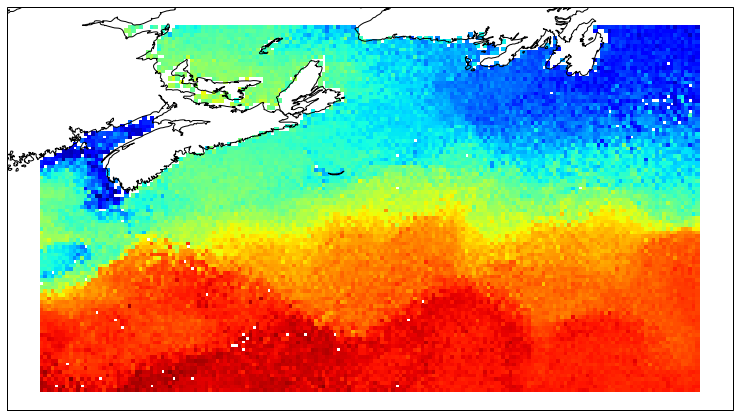

In [416]:
fig = plt.figure(figsize=(13,13)) # Create figure
ax = plt.axes(projection=ccrs.PlateCarree()) # Create axis within figure (with projection)
ax.pcolormesh(lons, lats, sst, cmap=plt.cm.jet, transform=ccrs.PlateCarree()) # Add colormap to axis (specifying projection of data) 
ax.coastlines(resolution='10m') # Add coastline to axis

You shuold try change the colormap one more time by changing the word `jet` in your code for the name of another colormap (see full list in the link above). 

### Bad "Jet" colormap, vs Good "perceptually uniform" colormaps

Note that many colormaps create visual artifacs because the human eye is more sensitive to some color gradients. Therefore it is very <span class="important"></span> to choose a **"perceptually uniform"** color gradient.

* Learn more about "bad" colormaps: https://matplotlib.org/cmocean/#why-jet-is-a-bad-colormap-and-how-to-choose-better

Lets change the colormap of your plot to one of the "perceptually uniform" maps included in the link above (e.g. `magma`). In you <span class='file'>mapSST.py</span>, replace the argument `cmap=plt.cm.jet` for the argument `cmap=plt.cm.magma`. This will activate the colormap "magma". 

<span class="run"></span> your code it again...

...or you can simply copy-paste the code below to console:

<div class="c2c"></div>

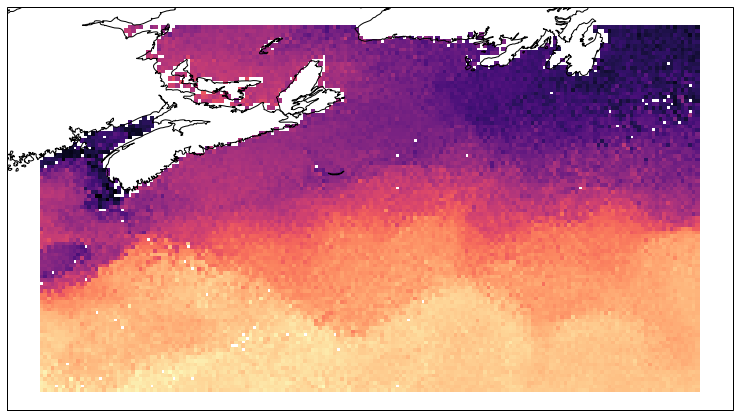

In [417]:
fig = plt.figure(figsize=(13,13)) # Create figure
ax = plt.axes(projection=ccrs.PlateCarree()) # Create axis within figure (with projection)
ax.pcolormesh(lons, lats, sst, cmap=plt.cm.magma, transform=ccrs.PlateCarree()) # Add colormap to axis (specifying projection of data) 
ax.coastlines(resolution='10m') # Add coastline to axis

### CMOCEAN: Oceanograpgic colormaps

The Python module `cmocean` includes many **"perceptually uniform"** colormaps specifically designed for oceanographic and marine purposes. You can learn more about "cmocean" here: https://matplotlib.org/cmocean/

You probably already have the `cmocean` module istalled (if so, skip this step). If not, open an `Anaconda Prompt` and type:

<div class='terminalBlock'>conda install -c conda-forge cmocean</div>

Now, lets change the colormap of your plot to one of the "perceptually uniform" colormaps included in `cmocean` (e.g. `thermal`). In you <span class='file'>mapSST.py</span>, replace the argument `cmap=plt.cm.magma` for the argument `cmap=cmocean.cm.thermal`. This will activate the colormap "thermal". 

<span class="run"></span> your code it again...

...or you can simply copy-paste the code below to console:

<div class="c2c"></div>

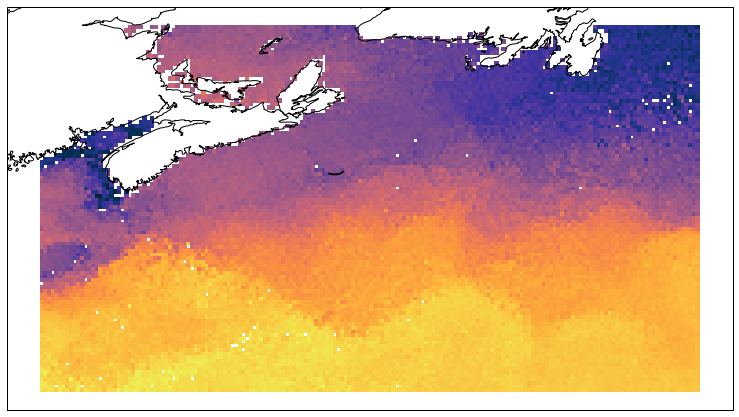

In [418]:
fig = plt.figure(figsize=(13,13)) # Create figure
ax = plt.axes(projection=ccrs.PlateCarree()) # Create axis within figure (with projection)
ax.pcolormesh(lons, lats, sst, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree()) # Add colormap to axis (specifying projection of data) 
ax.coastlines(resolution='10m') # Add coastline to axis

## Projections

All the previous maps where done with the "PlateCarree" projection. But you can change to other projections to give a different perspective to your data. THe full list of projections icluded in `cartopy` is here: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html

Lets change the projection of your plot. In you <span class='file'>mapSST.py</span>, replace the code line `ax = plt.axes(projection=ccrs.PlateCarree())` for the line `ax = plt.axes(projection=ccrs.Orthographic())`. This will activate the "Orthographic" projection. 

<span class="run"></span> your code it again...

...or you can simply copy-paste the code below to console:

<div class="c2c"></div>

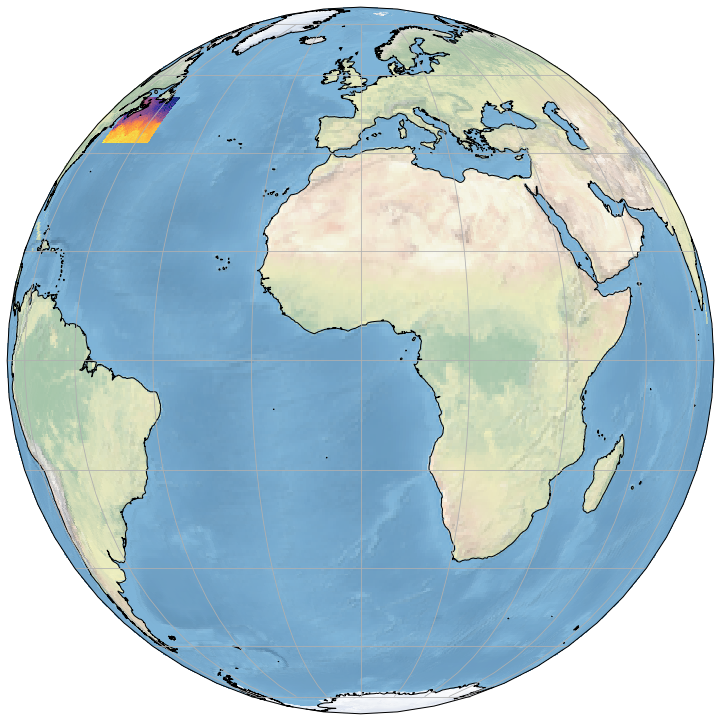

In [419]:
#%% Create map (Orthographic Projection) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW SECTION !!!!! <<<<<<<<<<<<<<<<<<<<<<<<<<<<<
fig = plt.figure(figsize=(13,13)) # Create figure
#ax = plt.axes(projection=ccrs.Orthographic(central_longitude=(maxlon+minlon)/2, central_latitude=(maxlat+minlat)/2)) # Create axis within figure (with projection)
ax = plt.axes(projection=ccrs.Orthographic()) # Create axis within figure (with projection)
ax.pcolormesh(lons, lats, sst, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree()) # Add colormap to axis (specifying projection of data) 
ax.coastlines(resolution='50m') # Add coastline to axis
ax.gridlines() # Add gridlines to axis
ax.set_global() #zoom out to see the whole globe
ax.stock_img() # Add background image to axis

Note we also added gridlines and a background image...

...also note that the default orientation of the map does not showcase well our data. To rotate the map, in you <span class='file'>mapSST.py</span>, add the following arguments to Ortograpgic projection so that it reads `ax = plt.axes(projection=ccrs.Orthographic(central_longitude=(maxlon+minlon)/2, central_latitude=(maxlat+minlat)/2))`. 

<span class="run"></span> your code it again...

...or you can simply copy-paste the code below to console:

<div class="c2c"></div>

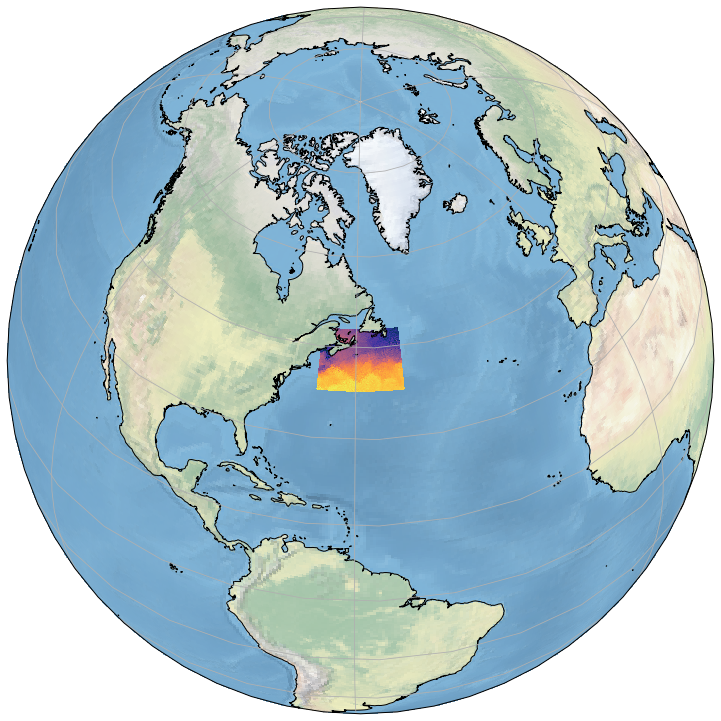

In [420]:
#%% Create map (Orthographic Projection) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW SECTION !!!!! <<<<<<<<<<<<<<<<<<<<<<<<<<<<<
fig = plt.figure(figsize=(13,13)) # Create figure
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=(maxlon+minlon)/2, central_latitude=(maxlat+minlat)/2)) # Create axis within figure (with projection)
ax.pcolormesh(lons, lats, sst, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree()) # Add colormap to axis (specifying projection of data) 
ax.coastlines(resolution='50m') # Add coastline to axis
ax.gridlines() # Add gridlines to axis
ax.set_global() #zoom out to see the whole globe
ax.stock_img() # Add background image to axis


Lets do one more map, but with a **Robinson** projection...

You can replace the `#%% Create map` section in <span class='file'>mapSST.py</span> with the code below and <span class="run"></span> it again.... or you can simply copy-paste the code below to console:

<div class="c2c"></div>

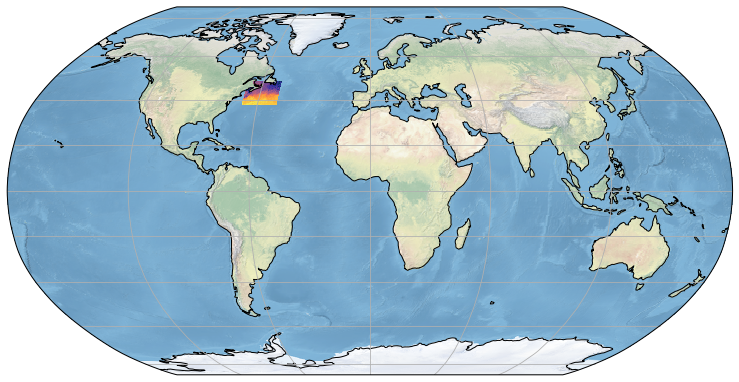

In [421]:
#%% Create map (Orthographic Projection) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW SECTION !!!!! <<<<<<<<<<<<<<<<<<<<<<<<<<<<<
fig = plt.figure(figsize=(13,13)) # Create figure
ax = plt.axes(projection=ccrs.Robinson()) # Create axis within figure (with projection)
ax.pcolormesh(lons, lats, sst, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree()) # Add colormap to axis (specifying projection of data) 
ax.coastlines(resolution='110m') # Add coastline to axis
ax.gridlines() # Add gridlines to axis
ax.set_global() #zoom out to see the whole globe
ax.stock_img() # Add background image to axis

Once again... a very different map emerged (i.e. Robinson projection). Make sure you understand what each line of the mapping code is doing.

### Publication-quality map

Lets do one last map. This time we'll add all the bells and whistles needed for publication (title, colorbar, units, etc). You may want to refer to this code at a later time, if you need to do a map for a paper or contract work...

Replace the `#%% Create map` section in <span class='file'>mapSST.py</span> with the code below and <span class="run"></span> it again.... or you can simply copy-paste the code below to console:

<div class="c2c"></div>

Text(0.5, 1.0, 'Satellite SST (Monthly composite for 2015/8)')

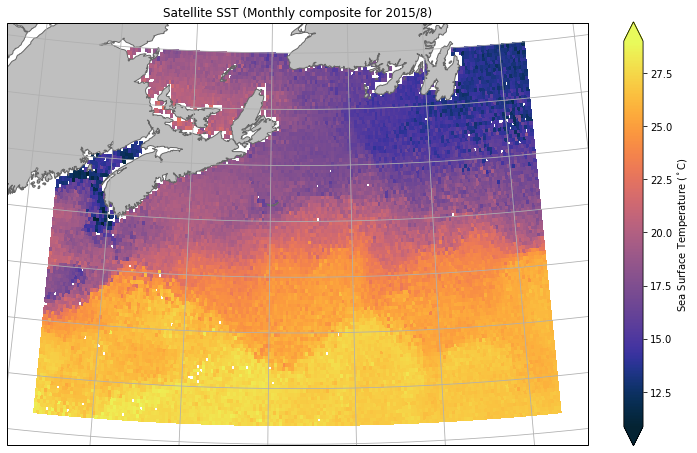

In [422]:
#%% Create map (LambertConformal Projection) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< NEW SECTION !!!!! <<<<<<<<<<<<<<<<<<<<<<<<<<<<<
fig = plt.figure(figsize=(13,13)) # Create figure
ax = plt.axes(projection=ccrs.LambertConformal(central_longitude=(maxlon+minlon)/2, central_latitude=(maxlat+minlat)/2)) # Create axis within figure (with projection)
cs = ax.pcolormesh(lons, lats, sst, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree()) # Add colormap to axis (specifying projection of data) 
cbar = fig.colorbar(cs, shrink=0.6, orientation='vertical', extend='both') # Add colorbar
cbar.set_label('Sea Surface Temperature ($^\circ$C)') # Add legend to colorbar
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='#666666', facecolor='#bfbfbf')) # Add land to axis
ax.gridlines() # Add gridlines to axis
plt.title('Satellite SST (Monthly composite for '+str(year)+'/'+str(month)+')') # Add title to figure

<div class="Q"><br>

What do you think causes the mass of <b>warm water</b> in the south of the colorplot (i.e. the "red band")?

<br><br><div class="qhelp"></div></div>

To save your map to your computer...

<div class="c2c"></div>

In [423]:
fig1.savefig('myplot.png')

-----------------

# PART 2: "Wrangling" data (preparing it to use it as forcing)

We know now how to get SST data, but it is not in a the format that we need. The SST data from above comes as "maps" (one map per month) and we need a **time-series** of temperature at a given point. Not a problem, we just need to "wrangle" and reshape our data before we can use it. We are going to write this new code in a separate file, <span class='file'>timeSeriesSST.py</span>, so that we can use it later.

Just as in last week's lab, we'll write several function plus a `if __name__ == "__main__":` statement to help us during development. The skeleton of the file is as follows:

Copy-paste the code below into <span class='file'>timeSeriesSST.py</span>. Don't forget to <span class="run"></span> your file! 

<span class="checkpoint">CHECKPOINT below...</span> 

In [424]:
def get_data():
    print('get_data....done!')
    return

def make_forcing():
    print('make_forcing....done!')
    return

def plot_data():
    print('plot_data....done!')
    return

          
          
          
if __name__ == "__main__":
    get_data()
    make_forcing()
    plot_data()

get_data....done!
make_forcing....done!
plot_data....done!


<div class="Q"><br>

How many <b>functions</b> are in the "block" of code above?

<br><br><div class="qhelp"></div></div>

Copy-paste the code below and REPLACE the contents of <span class='file'>timeSeriesSST.py</span>.

As you can see, we added a bunch of code inside the `get_data` function. The new code downloads data from NOAA's ERDDAP as we did before, but this time we get the data as a .csv file, which is a bit simpler than NetCDF. We made the `get_data` function to require `lat`, `lon`, `minday` and `maxday` arguments... and to return the downloaded data in the `sst` variable.

We also added code inside the `plot_data` function, which makes a plots of whatever data you give it through the `sst` variable.

Don't forget to <span class="run"></span> your file! 

<span class="checkpoint">CHECKPOINT below...</span> 


make_forcing....done!


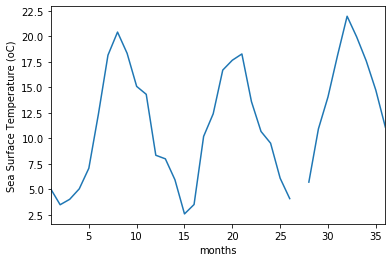

In [425]:
# Imports for the entire module
import pandas as pd

def get_data(lat,lon,minday,maxday):
    isub = 1

    base_url='http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.csv?'
    query='sst[('+minday+'):'+str(isub)+':('+maxday+')][(0.0):'+str(isub)+':(0.0)][('+str(lat)+'):'+str(isub)+':('+str(lat)+')][('+str(lon)+'):'+str(isub)+':('+str(lon)+')]'
    url = base_url+query
    print('Downloading Satellite Data from: POES, AVHRR and GAC (Time-series)...')

    data = pd.read_csv(url)
    sst = data['sst'][1:].astype(float)
    return sst

def make_forcing():
    print('make_forcing....done!')
    return

def plot_data(sst):
    ax = sst.plot()
    ax.set_xlabel('months')
    ax.set_ylabel('Sea Surface Temperature (oC)')
    return

          
          

if __name__ == "__main__":

    lat = 43
    lon = -62
    minday='2010-01-01T12:00:00Z'
    maxday='2012-12-31T12:00:00Z'
    
    sst = get_data(lat,lon,minday,maxday)
    make_forcing()
    plot_data(sst)

<div class="Q"><br>

Roughly reading from the graph above, how many "summers" are shown in the graph?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

Roughly reading from the graph above, what is the water temperature during the <b>summers</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

Roughly reading from the graph above, what is the water temperature during the <b>winters</b>?

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

Are there any gaps in the data?

<br><br><div class="qhelp"></div></div>

Copy-paste the code below and REPLACE the contents of <span class='file'>timeSeriesSST.py</span>.

As you can see, this time around we added a bunch of code inside the `make_forcing` function. This code takes as input the data that you just downloaded using the `get_data` function and it does to it 2 things:

* It stretches the data to match the length the model output
* It fills any gaps in the data

This function does all the "data wrangling" for us.

Don't forget to <span class="run"></span> your file! 

<span class="checkpoint">CHECKPOINT below...</span> 


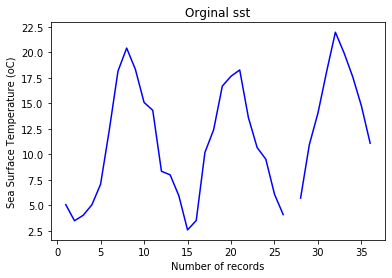

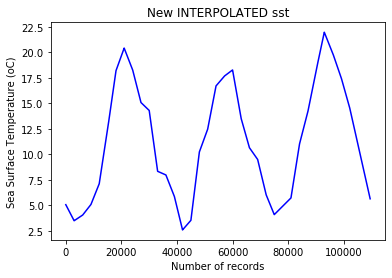

In [426]:
# Imports for the entire module
import pandas as pd

def get_data(lat,lon,minday,maxday):
    isub = 1

    base_url='http://coastwatch.pfeg.noaa.gov/erddap/griddap/erdAGsstamday_LonPM180.csv?'
    query='sst[('+minday+'):'+str(isub)+':('+maxday+')][(0.0):'+str(isub)+':(0.0)][('+str(lat)+'):'+str(isub)+':('+str(lat)+')][('+str(lon)+'):'+str(isub)+':('+str(lon)+')]'
    url = base_url+query
    print('Downloading Satellite Data from: POES, AVHRR and GAC (Time-series)...')

    data = pd.read_csv(url)
    sst = data['sst'][1:].astype(float)
    return sst

def make_forcing(days,dt,sst):
    # Resize array and Eliminate Gaps by Interpolating in between
    import scipy.interpolate as intrp
    import numpy as np

    months = len(sst)

    x = np.arange(0, months)

    f = intrp.interp1d(x, sst, kind='linear', fill_value='extrapolate' )

    NoSTEPS = int(days / dt)
    newx = np.linspace(0,days/30,NoSTEPS) # Makes and vector array of equally spaced numbers from zero to "days"

    new_sst = f(newx)

    # Get rid of nans
    nans, x= np.isnan(new_sst), lambda z: z.nonzero()[0]
    new_sst[nans]= np.interp(x(nans), x(~nans), new_sst[~nans])
    return new_sst

def plot_data(sst,title='SST'):
    import matplotlib.pyplot as plt
    fig, (ax) = plt.subplots(1,1)
    ax.plot(sst,'b-')
    #ax = sst.plot()
    ax.set_xlabel('Number of records')
    ax.set_ylabel('Sea Surface Temperature (oC)')
    ax.set_title(title)
    return

          
          

if __name__ == "__main__":

    lat = 43
    lon = -62
    minday='2010-01-01T12:00:00Z'
    maxday='2012-12-31T12:00:00Z'
    days = 365 * 3
    dt = 0.01
    
    sst = get_data(lat,lon,minday,maxday)
    new_sst = make_forcing(days,dt,sst)

    plot_data(sst, title='Orginal sst')

    plot_data(new_sst, title='New INTERPOLATED sst')
    

<div class="Q"><br>

How many records are in the original <b>sst</b> dataset?

<br><br>hint: use the <b>len()</b> function

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

How many records are in <b>new_sst</b>, which was just output by the make_forcing function?

<br><br>hint: use the <b>len()</b> function

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

After applying the interpolation, are there any gaps in the <b>new_sst</b> data?

<br><br><div class="qhelp"></div></div>

-----------------

## Modifying model_SHELLE.py to accept forcing

First, lets run the "old" SHELLE model. Make sure you have the <span class='file'>model_SHELLE.py</span> file in your working directory. If not, download a copy from Brightspace.

Then you simply copy-paste the following to console:

<div class="c2c"></div>

Loading defaults...
Running model...
Model run: DONE!!!


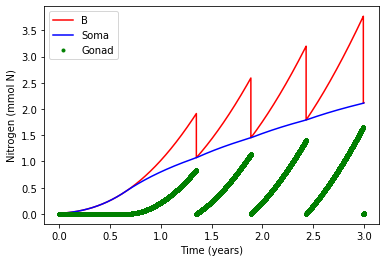

L_Temp = 0.8207764716002266
L_Salt = 0.9932620530009145
L_Oxy  = 0.9984194778312638
L_Food  = 0.5652173913043478


In [427]:
import model_SHELLE as model

# load default parameters
days, dt, par, InitCond = model.load_defaults()

#Change Temperature
InitCond['Temp'] = 11

 # run the model
output = model.run(days, dt, par, InitCond)

# plot model
model.plot(output)

Here is what happened:

* First we imported our "old" SHELL-E model: `import model_SHELLE as model`
* Then we loaded the default parameters: `days, dt, par, InitCond = model.load_defaults()`
* Then we changed the default temperature for 11 oC: `InitCond['Temp'] = 11`
* Then we ran the model with the default parameters (except for Temp, which was 11): `output = model.run(days, dt, par, InitCond)` 
* ...and we plotted the results: `model.plot(output)`

Note that in this version of the SHELL-E model, you insert Temperature as a single value `InitCond['Temp']`, which then remains constant throughout the whole experiment. 

In the next section we will modify the SHELL-E model to accept a time-series of temperature (rather than a single value).

-----------------

### Modifying SHELLE to accept NOAA's SST forcing

In Spyder, open your <span class='file'>model_SHELLE.py</span> file and **Save it AS** with this different name: <span class='file'>model_SHELLE_sstForcing.py</span>. 

In the new copy (i.e. <span class='file'>model_SHELLE_sstForcing.py</span>) do the following:

* Find `def run(days, dt, par, InitCond):` and replace for `def run(days, dt, par, InitCond, Temp):` ...this basically request one additional INPUT, i.e. `Temp`

* Find `InitCond['Temp'] = 10` ...and delete that line. We won't need `InitCond['Temp']` anymore.

* Go to "Search" > "Replace text", and find all instances of `InitCond['Temp']` and replace them with `Temp[t]`. As you see every time we used to employ the single constant value of `InitCond['Temp']`, now we will employ instead the value of `Temp` at time `[t]`.

That's it! Make sure to save <span class='file'>model_SHELLE_sstForcing.py</span>.

You can see the final product in Brightspace: <span class='file'>model_SHELLE_sstForcing.py</span> or <a href="https://bitbucket.org/Diego_Ibarra/aquaculturemodelling2017/raw/tip/Week4/model_SHELLE_sstForcing.py">HERE</a>

Copy-paste the following into console:

<div class="c2c"></div>

Loading defaults...
Running model...
Model run: DONE!!!


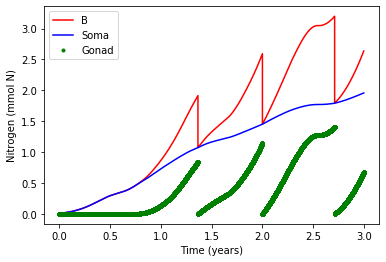

L_Temp = 0.9320669688719911
L_Salt = 0.9932620530009145
L_Oxy  = 0.9984194778312638
L_Food  = 0.5652173913043478


In [428]:
import model_SHELLE_sstForcing as model
import timeSeriesSST

# load default parameters
days, dt, par, InitCond = model.load_defaults()

# Download SSt data (from NOAA)
lat = 43
lon = -62
minday='2010-01-01T12:00:00Z'
maxday='2012-12-31T12:00:00Z'
sst = timeSeriesSST.get_data(lat,lon,minday,maxday)

# Interpolate and re-shape SST so that it matches model framework
new_sst = timeSeriesSST.make_forcing(days,dt,sst)

# run the NEW model with forcing
output = model.run(days, dt, par, InitCond, new_sst)

# plot model
model.plot(output)

Here is what happened:

* First we imported our "NEW" SHELL-E model: `import model_SHELLE_sstForcing as model`
* We also imported our new Interpolation module that we just finished above: `import timeSeriesSST`
* Then we loaded the default parameters: `days, dt, par, InitCond = model.load_defaults()`
* We used our new Interpolation module to download data from NOAA's ERDDAP: `sst = timeSeriesSST.get_data(lat,lon,minday,maxday)`
* We used our new Interpolation module to interpolate the downloaded data: `new_sst = timeSeriesSST.make_forcing(days,dt,sst)`
* Then we ran the model with the default parameters AND the interpolated data: `output = model.run(days, dt, par, InitCond, new_sst)` 
* ...and we plotted the results: `model.plot(output)`

<div class="Q"><br>

Looking at the previous two graphs (i.e. "WITHOUT sst forcing" and "WITH sst forcing") can you see the differences?

<br><br><div class="qhelp"></div></div>

-----------------

# PART 3: EXPERIMENT - Effect of global warming of mussel growth

Here we will use our new model `model_SHELLE_sstForcing` to assess the effect of Global Warming on the growth of our mussel. Essentially we will run the model 6 different times, each time with incrementally higher temperature.

In the empty file you created above, <span class='file'>GlobalWarming_experiment.py</span>, copy-paste the following code and click <span class='run'></span>

<span class="checkpoint">CHECKPOINT below...</span> 

Loading defaults...
Running model...
Model run: DONE!!!
Running model...
Model run: DONE!!!
Running model...
Model run: DONE!!!
Running model...
Model run: DONE!!!
Running model...
Model run: DONE!!!
Running model...
Model run: DONE!!!


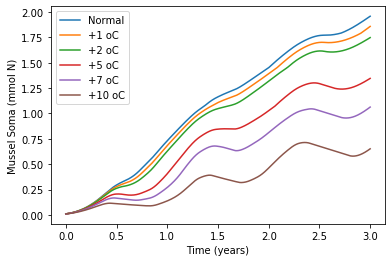

In [429]:
import model_SHELLE_sstForcing as model
import timeSeriesSST

# load default parameters
days, dt, par, InitCond = model.load_defaults()

# Download SSt data (from NOAA)
lat = 43
lon = -62
minday='2010-01-01T12:00:00Z'
maxday='2012-12-31T12:00:00Z'
sst = timeSeriesSST.get_data(lat,lon,minday,maxday)

# Interpolate and re-shape SST so that it matches model framework
new_sst = timeSeriesSST.make_forcing(days,dt,sst)

# run the NEW model with forcing
output_0 =  model.run(days, dt, par, InitCond, new_sst+0)
output_1 =  model.run(days, dt, par, InitCond, new_sst+1)
output_2 =  model.run(days, dt, par, InitCond, new_sst+2)
output_5 =  model.run(days, dt, par, InitCond, new_sst+5)
output_7 = model.run(days, dt, par, InitCond, new_sst+7)
output_10 = model.run(days, dt, par, InitCond, new_sst+10)

# plot model
# plot model
import matplotlib.pyplot as plt
fig, (ax) = plt.subplots(1,1)
ax.plot(output_0['time']/365,output_0['Soma'],'-') 
ax.plot(output_1['time']/365,output_1['Soma'],'-') 
ax.plot(output_2['time']/365,output_2['Soma'],'-') 
ax.plot(output_5['time']/365,output_5['Soma'],'-') 
ax.plot(output_7['time']/365,output_7['Soma'],'-') 
ax.plot(output_10['time']/365,output_10['Soma'],'-')
ax.legend(['Normal', '+1 oC','+2 oC','+5 oC','+7 oC','+10 oC'], loc="upper left") 
ax.set_ylabel('Mussel Soma (mmol N)') 
ax.set_xlabel('Time (years)')
plt.show() 

Note that every time we ran the model, we increased the temperature of `new_sst`. For example, in `output_2 =  model.run(days, dt, par, InitCond, new_sst+2)`, we used the temperature `new_sst+2` which was the downloaded SST data **PLUS 2 degrees** (i.e. every temperature in the `new_sst` array was increased by 2 degrees).

<div class="Q"><br>

Based on your modelling experiment, what happened to mussel growth in our farm as the water gets progressively warmer?

<br><br><div class="qhelp"></div></div>

### Putting it all together

In modelling, we often need to "synthesize" the outcome of several model runs into one single graph. In the graph below we calculate the "Percent decrease in mussel Soma after 3 years or growth" compared to the scenario with no Global Warming.

Copy-paste the code below to the console (you could also copy-paste it to the end of <span class='file'>GlobalWarming_experiment.py</span> and run the file).

<div class="c2c"></div>

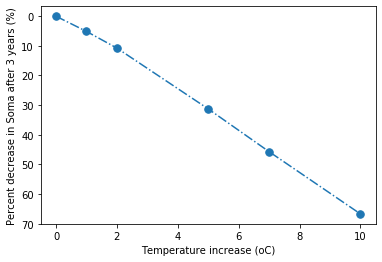

In [430]:
# Plot "Percent decrease vs Temperature"
TempScenarios = [0,1,2,5,7,10]

PercentDecrease =[]
PercentDecrease.append(100-((output_0['Soma'][-1] / output_0['Soma'][-1])*100))
PercentDecrease.append(100-((output_1['Soma'][-1] / output_0['Soma'][-1])*100))
PercentDecrease.append(100-((output_2['Soma'][-1] / output_0['Soma'][-1])*100))
PercentDecrease.append(100-((output_5['Soma'][-1] / output_0['Soma'][-1])*100))
PercentDecrease.append(100-((output_7['Soma'][-1] / output_0['Soma'][-1])*100))
PercentDecrease.append(100-((output_10['Soma'][-1] / output_0['Soma'][-1])*100))

# plot model
import matplotlib.pyplot as plt
fig2, (ax2) = plt.subplots(1,1)
ax2.plot(TempScenarios,PercentDecrease,'.-.', markersize=15)
ax2.set_xlabel('Temperature increase (oC)') 
ax2.set_ylabel('Percent decrease in Soma after 3 years (%)')
ax2.invert_yaxis()
plt.show() 

<div class="Q"><br>

Based on your modelling experiments, what do you think will be the "Percent decrease in Soma after 3 years (%)" if the water heats up by <b>3 degrees</b>?

<br><br>Hint: Read from graph above.

<br><br><div class="qhelp"></div></div>

<div class="Q"><br>

Based on your modelling experiments, what will be effect of <b>6 degrees</b> warming on the pH of the water?

<br><br><div class="qhelp"></div></div>

_Please beware that this model was designed as a teaching tool and may not be adequate to represent realistic applications_.

# **This is the end of lab**

*******************
*******************

Code below is for formatting of this lab. Do not alter!

In [431]:
# Loads css file and applies it to lab HTML
from IPython.core.display import HTML
def css():
    style = open("../css/custom.css", "r").read()
    return HTML(style)
css()